## Lab 7: Resampling and the Bootstrap

The British Royal Air Force wanted to know how many warplanes the Germans had (some number `N`, which is a *population parameter*), and they needed to estimate that quantity knowing only a random sample of the planes' serial numbers (from 1 to `N`). We know that the German's warplanes are labeled consecutively from 1 to `N`, so `N` would be the total number of warplanes they have. 

We normally investigate the random variation amongst our estimates by simulating a sampling procedure from the population many times and computing estimates from each sample that we generate.  In real life, if the RAF had known what the population looked like, they would have known `N` and would not have had any reason to think about random sampling. However, they didn't know what the population looked like, so they couldn't have run the simulations that we normally do.  

Simulating a sampling procedure many times was a useful exercise in *understanding random variation* for an estimate, but it's not as useful as a tool for practical data analysis.

Let's flip that sampling idea on its head to make it practical. Given *just* a random sample of serial numbers, we'll estimate `N`, and then we'll use simulation to find out how accurate our estimate probably is, without ever looking at the whole population.  This is an example of *statistical inference*.

As usual, **run the cell below** to prepare the lab and the automatic tests.

In [1]:
# Run this cell to set up the notebook, but please don't change it.

# These lines import the Numpy and Datascience modules.
import numpy as np
from datascience import *

# These lines do some fancy plotting magic.
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import warnings
warnings.simplefilter('ignore', FutureWarning)

# These lines load the tests.
from client.api.notebook import Notebook
ok = Notebook('lab07.ok')
_ = ok.auth(inline=True)

ERROR  | auth.py:102 | {'error': 'invalid_grant'}


Assignment: Resampling and the Bootstrap
OK, version v1.14.15


Open the following URL:

https://okpy.org/client/login/

After logging in, copy the code from the web page and paste it into the box.
Then press the "Enter" key on your keyboard.

Paste your code here: WvUoQYxCIZLOyG8KhVfVeNk4h0L3df
Successfully logged in as rga2uz@virginia.edu


## 1. Preliminaries
We (the RAF in World War II) want to know the number of warplanes fielded by the Germans.  That number is `N`.  The warplanes have serial numbers from 1 to `N`, so `N` is also equal to the largest serial number on any of the warplanes.

We only see a small number of serial numbers (assumed to be a random sample with replacement from among all the serial numbers), so we have to use estimation.

#### Question 1.1
Is `N` a population parameter or a statistic?  If we compute a number using our random sample that's an estimate of `N`, is that a population parameter or a statistic?

In statistics, a population parameter is summary number, such as an average or a percentage, that describes an entire population; it is a true value, not an estimate. A statistic is a summary number that describes one sample drawn from the population. N is equal to the total number of warplanes; this is our population parameter. Any number we compute using our random sample that is an estimate of N is a statistic.

Check your answer with a neighbor.

The true number of warplanes is hidden from you. You have access only to this random sample (which was recovered from one of your spies):

In [2]:
observations = Table.read_table("serial_numbers.csv")
num_observations = observations.num_rows
observations.show()

serial number
47
42
57
79
26
23
36
64
83
135


#### Question 1.2
Define a function named `plot_serial_numbers` to make a histogram of any table of serial numbers.  It should take one argument, a table like `observations` with one column called `"serial number"`.  It should plot a histogram of the values in the column **using bins of width 1** ranging from **1 to 200** but return nothing.  Then, call that function to make a histogram of `observations`.

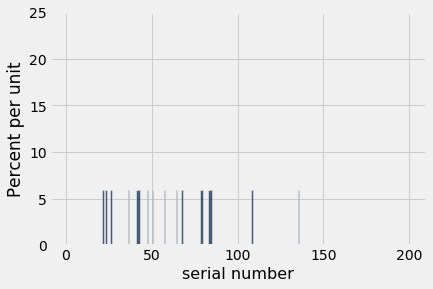

In [3]:
def plot_serial_numbers(numbers):
    numbers.hist("serial number", bins = np.arange(1,201,1))
    
    # Assuming the lines above produce a histogram, this next
    # line may make your histograms look nicer.  Feel free to
    # delete it if you want.
    plt.ylim(0, .25)

plot_serial_numbers(observations)

#### Question 1.3
By looking at the histogram, what can we say about `N` immediately? (Hint: What is the relationship between `N` and the largest serial number in `observations`?) What does each little bar in the histogram represent and why are all the bars the same height?

We know that N is at least equal to or greater than 135, the largest serial number in the distribution. Each little bar in the histogram represents on serial number from the observations table. Each bar is the same height because no one number is repeated in the observations table; each serail number represents the same percentage of the total number of serial numbers (percent per unit).

#### Question 1.4
One way to estimate `N` is to take twice the mean of the serial numbers we see. Write a function that computes that statistic.  It should take as its argument an array of serial numbers and return twice their mean.  Call it `mean_based_estimator`.  

After that, use it to compute an estimate of `N` called `mean_based_estimate`.

In [4]:
def mean_based_estimator(nums):
    return np.average(nums) * 2

mean_based_estimate = mean_based_estimator(observations.column(0))
mean_based_estimate

122.47058823529412

In [5]:
_ = ok.grade('q1_4')

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



#### Question 1.5
We can also estimate `N` by using the biggest serial number in the sample.  Compute it, giving it the name `max_estimate`.

In [6]:
max_estimate = np.max(observations.column(0))
max_estimate

135

In [7]:
_ = ok.grade('q1_5')

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



#### Question 1.6
Look at the values of `max_estimate` and `mean_based_estimate` that we happened to get for our dataset.  The value of `max_estimate` tells you something about `mean_based_estimate`.  For these specific values, is it possible for our value  of `mean_based_estimate` to be equal to `N` (at least, if we round it to the nearest integer)?  If not, is it definitely higher, definitely lower, or can we not tell?  Can you make a statement like the value of our "`mean_based_estimate` is at least *[fill in a number]* away from `N`"?

The value of max_estimate, or 135, is larger than the value of mean_based_estimate, or about 122 if rounded to the nearest integer. For these specific values, it is not possible for our value of mean_based_estimate to be equal to N. If N is the actual number of warplanes, and these warplanes are numbered 1 to N, then we know based on our observation that there are at least 135 warplanes. Therefore, we can say that our value of mean_based_estimate is at least 13 away from N. 

Check your answer with a neighbor.

We can't just confidently proclaim that `max_estimate` or `mean_based_estimate` is equal to `N`.  What if we're really far off?  So we want to get a sense of the accuracy of our estimates.

## 2. Resampling
To do this, we'll use resampling.  That is, we won't exactly simulate the observations the RAF would have really seen.  Rather we sample from our current sample, or "resample."

Why does that make any sense?

When we tried to estimate `N`, we would have liked to use the whole population.  Since we had only a sample, we used that to estimate `N` instead.

This time, we would like to use the population of serial numbers to *run a simulation* about estimates of `N`.  But we still only have our sample.  We use our sample in place of the population to run the simulation.

So there is a simple analogy between estimating `N` and simulating the variability of estimates.

$$\text{computing }N\text{ from the population}$$
$$:$$
$$\text{computing an estimate of }N\text{ from a sample}$$

$$\text{as}$$

$$\text{simulating the distribution of estimates of }N\text{ using samples from the population}$$
$$:$$
$$\text{simulating an (approximate) distribution of estimates of }N\text{ using resamples from a sample}$$

#### Question 2.1
Write a function called `simulate_resample`.  It should generate a resample from the observed serial numbers in `observations` and return that resample.  (The resample should be the `observations` table.)  It should take no arguments.

In [8]:
def simulate_resample():
    return observations.sample(observations.num_rows, with_replacement = True)

Let's make one resample.

In [10]:
# This is a little magic to make sure that you see the same results
# we did.
np.random.seed(123)

one_resample = simulate_resample()
one_resample

serial number
108
57
57
36
41
42
47
50
135
47


In [11]:
_ = ok.grade('q2_1')

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



Later, we'll use many resamples at once to see what estimates typically look like.  We don't often pay attention to single resamples, so it's easy to misunderstand them.  Let's examine some individual resamples before we start using them.

#### Question 2.2
Make a histogram of your resample using the plotting function you defined earlier in this lab, **and** a separate histogram of the original observations.

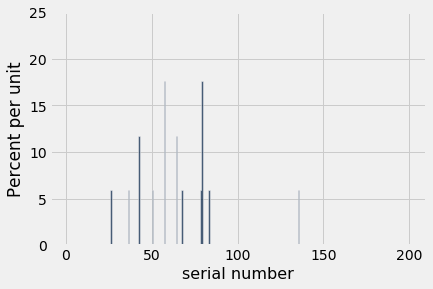

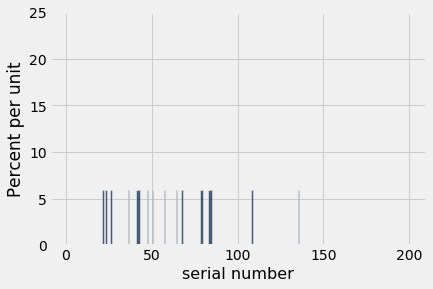

In [12]:
plot_serial_numbers(simulate_resample())
plot_serial_numbers(observations)

#### Question 2.3
Which of the following are true:
1. In the plot of the resample, there are no bars at locations that weren't there in the plot of the original observations.
2. In the plot of the original observations, there are no bars at locations that weren't there in the plot of the resample.
3. The resample has exactly one copy of each serial number.
4. The sample has exactly one copy of each serial number.

Assign true_statements to a list of the correct statements. Be careful: the test provided does not guarantee full points for this question.

In [13]:
true_statements = [1,4]

In [14]:
_ = ok.grade('q2_3')

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



#### Question 2.4
Create two more resamples using the function `simulate_resample` from above. For each resampled data, plot it and compute its max- and mean-based estimates.

Mean-based estimate for resample 0: 106.82352941176471
Max-based estimate for resample 0: 108
Mean-based estimate for resample 1: 126.3529411764706
Max-based estimate for resample 1: 135


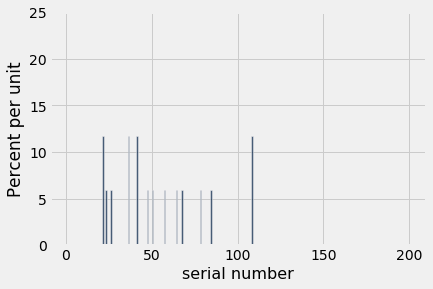

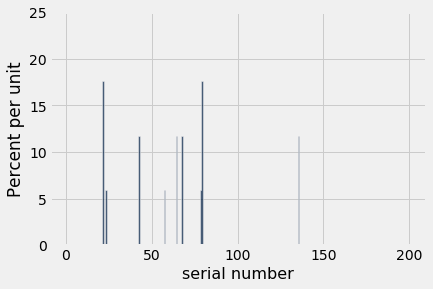

In [15]:
resample_0 = simulate_resample()
plot_serial_numbers(resample_0)
mean_based_estimate_0 = mean_based_estimator(resample_0.column(0))
max_based_estimate_0 = np.max(resample_0.column(0))
print("Mean-based estimate for resample 0:", mean_based_estimate_0)
print("Max-based estimate for resample 0:", max_based_estimate_0)

resample_1 = simulate_resample()
plot_serial_numbers(resample_1)
mean_based_estimate_1 = mean_based_estimator(resample_1.column(0))
max_based_estimate_1 = np.max(resample_1.column(0))
print("Mean-based estimate for resample 1:", mean_based_estimate_1)
print("Max-based estimate for resample 1:", max_based_estimate_1)

You may find that the max-based estimates from the resamples are both exactly the same.  You will probably find that the two mean-based estimates do differ from the sample mean-based estimate (and from each other).

#### Question 2.5
Using probability that you've learned, compute the exact chance that a max-based estimate from *one* resample is 135. Assign your answer to the variable `exact_prob_of_exact`.

Using your intuition, explain in words why a mean-based estimate from a resample is less often exactly equal to the mean-based estimate from the original sample as compared to a max-based estimate.

As a refresher, here are some rules of probability that may be helpful:

- When all outcomes are equally likely: P(event happens) $=$ $\frac{\text{# outcomes that make event happen}}{\text{# of all outcomes}}$

- When an event can happen in 2 ways: P(event) $=$ P(event happening first way) $+$ P(event happening second way)

- When 2 events must both happen: P(2 events both happen) $=$ P(one event happens) $*$ P(other event happens, given the first one happened)

- When an event doesn't happen: P(event doesn't happen) $=$ 1 $-$ P(event does happen)

- P(at least one success) $= 1 - $ P(no successes)

In [17]:
exact_prob_of_exact = 1 - (16/17)**17

Discuss your answers with a neighbor.

## 3. Simulating with resampling
Since resampling from a sample looks just like sampling from a population, the code should look almost the same.  That means we can write a function that simulates the process of either sampling from a population or resampling from a sample.  If we pass in population as its argument, it will do the former; if we pass in a sample, it will do the latter.

#### Question 3.1
Write a function called `simulate_estimates`.  It should take 4 arguments:
1. A table from which the data should be sampled.  The table will have 1 column named `"serial number"`.
2. The size of each sample from that table, an integer.  (For example, to do resampling, we would pass for this argument the number of rows in the table.)
3. A function that computes a statistic of a sample.  This argument is a *function* that takes an array of serial numbers as its argument and returns a number.
4. The number of replications to perform.

It should simulate many samples with replacement from the given table.  (The number of samples is the 4th argument.)  For each of those samples, it should compute the statistic on that sample. Then it should return an array containing each of those statistics.  The code below provides an example use of your function and describes how you can verify that you've written it correctly.

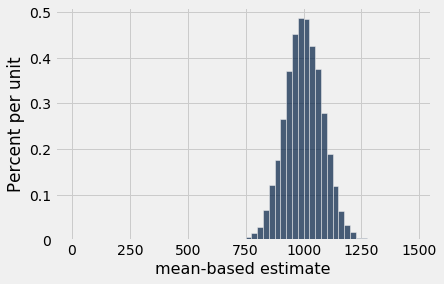

In [18]:
def simulate_estimates(original_table, sample_size, statistic, num_replications):
    # Our implementation of this function took 5 short lines of code.
    stats_array = make_array()
    for i in np.arange(num_replications):
        resampled = original_table.sample(sample_size, with_replacement = True)
        stats_array = np.append(stats_array, statistic(resampled.column(0)))
        
    return stats_array
        

# This should generate an empirical histogram of twice-mean estimates
# of N from samples of size 50 if N is 1000.  This should be a bell-shaped
# curve centered at 1000 with most of its mass in [800, 1200].  To verify your
# answer, make sure that's what you see!
example_estimates = simulate_estimates(
    Table().with_column("serial number", np.arange(1, 1000+1)),
    50,
    mean_based_estimator,
    10000)
Table().with_column("mean-based estimate", example_estimates).hist(bins=np.arange(0, 1500, 25))

Now we can go back to the sample we actually observed (the table `observations`) and estimate how much our mean-based estimate of `N` would have varied from sample to sample.

#### Question 3.2
Using the bootstrap and the sample `observations`, simulate the approximate distribution of *mean-based estimates* of `N`.  Use 5,000 replications.  
We have provided code that plots a histogram, allowing you to visualize the simulated estimates; let this suffice for an `ok.grade` test.

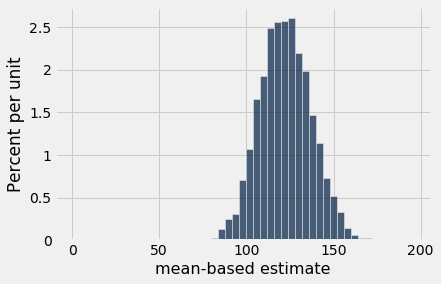

In [19]:
bootstrap_estimates = simulate_estimates(observations, num_observations, mean_based_estimator, 5000)


Table().with_column("mean-based estimate", bootstrap_estimates).hist(bins=np.arange(0, 200, 4)) 

#### Question 3.3
Compute an interval that covers the middle 95% of the bootstrap estimates.  Verify that your interval looks like it covers 95% of the area in the histogram above.

In [20]:
left_end = percentile(2.5, bootstrap_estimates)
right_end = percentile(97.5, bootstrap_estimates)
print("Middle 95% of bootstrap estimates: [{:f}, {:f}]".format(left_end, right_end))

Middle 95% of bootstrap estimates: [94.823529, 151.882353]


#### Question 3.4
Your mean-based estimate of `N` should have been around 122. Given the above calculations, is it likely that `N` is exactly 122? If not, what is the typical range of values of the mean-based estimates of `N` for samples of size 17?

We know from our table of obervations that N is not exactly 122; this is impossible because the max of the observed values is 135. The typical range of values of the mean_based estimates for samples of size 17, based on our boostrap simulations, is about 95 to 152.

#### Question 3.5
`N` was actually 150!  Write code that simulates the sampling and bootstrapping process again, as follows:

1. Generate a new set of random observations the RAF might have seen by sampling from the population table we have created for you below. 
2. Compute an estimate of `N` from these new observations, using `mean_based_estimator`.
3. Using only the new observations, compute 5,000 bootstrap estimates of `N`.
4. Plot these bootstrap estimates and compute an interval covering the middle 95%.

New mean-based estimate: 167.529412
Middle 95% of bootstrap estimates: [130.941176, 204.823529]


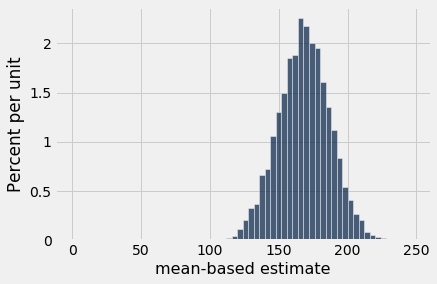

In [30]:
population = Table().with_column("serial number", np.arange(1, 150+1))

new_observations = population.sample(num_observations, with_replacement = True)
new_mean_based_estimate = mean_based_estimator(new_observations.column("serial number"))

new_bootstrap_estimates = simulate_estimates(new_observations, num_observations, mean_based_estimator, 5000)
Table().with_column("mean-based estimate", new_bootstrap_estimates).hist(bins=np.arange(0, 250, 4))

new_left_end = percentile(2.5, new_bootstrap_estimates)
new_right_end = percentile(97.5, new_bootstrap_estimates)

print("New mean-based estimate: {:f}".format(new_mean_based_estimate))
print("Middle 95% of bootstrap estimates: [{:f}, {:f}]".format(new_left_end, new_right_end))

#### Question 3.6
Does the interval covering the middle 95% of the new bootstrap estimates include `N`?  If you ran that cell many times, what is the probability that it will include `N`?

Yes, the interval of the new bootsrap estimates include N. The probability that it will include N if ran many times is 95%.

## BONUS: Question 4 Carnival Ring Toss
Welcome to the bonus question of Lab 7! Like other bonus questions, doing this problem won't count for or against you. It's just here for some extra practice if you would like some. 

At the Data 8 Annual Carnival Ring Toss game, you are given 100 rings per game. You will win the grand prize of a life-size Data 8 Bear if 60 rings out of 100 land on the bottles. As you may have guessed, carnival owners purposely make the probability of winning very small and sometimes, it is nearly impossible to win the cute life-size Data 8 Bear. Suppose for each ring, the probability of you landing the ring perfectly on the bottle is $.5$. How likely are you to win the grand prize?

#### Question 4.1
Use Chebyshev's bound to find out how likely it is for you to win the grand prize by landing 60 or more rings out of 100, with probability of you landing each ring on the bottle of .5. To refresh your memory, the Chebyshev's Ineuquality says that for all lists, and all numbers $z$ , the proportion of entries that are in the range "average $z \pm$ SDs" is at least  $1− \frac{1}{z^2}$. In mathematical form, the Chebyshev's Ineuquality can be expressed as:

$P( \mid Z - average \mid \geqslant z \sigma) \leq \frac{1}{z^2}$.

The ring toss distribution can modeled as a distribution with P(ring landing on the bottle) = 1 and P(ring not landing on the bottle) = 0, each with probability 0.5. This distribution has an average of 50 and standard deviation of 5.

1. Write a function called `chebyshev_bound`.  It should take 1 argument which is the number of standard deviations away from the average, or `zSDs`. (For example, if our observed value is 10 standard deviations away from the average value, `zSDs` = 10.) It should return the maximum proportion of values greater than or equal to zSDs standard deviations away from the average given by the Chebyshev's Inequality. The code below provides an example use of your function and describes how you can verify that you've written it correctly.
2. Set the result of `chebyshev_bound` with the appropriate `zSDs` that corresponds to landing 60 rings out of 100 to `chebyshev_upper_limit`.

In [2]:
def chebyshev_bound(zSDs):
    ...
chebyshev_upper_limit = ...
print("The probability of landing 60 or more rings is at most", chebyshev_upper_limit) 

In [ ]:
_ = ok.grade('q4_1')
_ = ok.backup()

In [ ]:
# DO NOT CHANGE THIS CELL
def ring_toss(num_games):
    successful_tosses = make_array()
    for i in np.arange(num_games):
        single_game = np.random.choice(make_array(0, 1), 100)
        successful_tosses = np.append(successful_tosses, sum(single_game))
    outcomes = Table().with_column("# of Rings Landing on the Bottle (Per Game)", successful_tosses)
    return outcomes

#### Question 4.2
Now we are going to simulate this ring tossing process in order to calculate how likely it is for you to win the grand prize by landing 60 or more rings out of 100 in practice, with probability of you landing each ring on the bottle of $.5$. Use the function `ring_toss` to simulate 50 games and calculate the observed probability of you winning the grand prize by landing 60 or more rings on the bottles.

1. Call `ring_toss` with the appropriate `num_games` you want to simulate and set it to `simulations`.
2. In the second cell, calculate the observed probability of games won in `simulations` and set it to `prob_winning`. 

In [ ]:
simulations = ...
simulations

In [ ]:
prob_winning = ...
print("The probability of landing 60 or more rings out of 100 games under simulations is", prob_winning)

In [ ]:
_ = ok.grade('q4_2')
_ = ok.backup()

As for your reference, the actual probability of you landing 60 or more rings on the bottle is $ \binom{100}{60} .5^{60} * .5^{100-60}$ which is about $0.01$. It is important to note that Chebychev's Inequailty gives an upper bound, not an exact value or an approximation. What makes the result powerful is that it is true for all lists – all distributions, no matter how irregular. As we saw, the probability of winning in the range "average $+2$ SDs" under the simulations is quite a bit lower than the upper bound given by the Chebychev's Inequality. 

Congratulations, you're done with lab 7!  Be sure to 
- **run all the tests** (the next cell has a shortcut for that), 
- **Save and Checkpoint** from the `File` menu,
- **run the last cell to submit your work**,
- and ask one of the staff members to check you off.

In [31]:
# For your convenience, you can run this cell to run all the tests at once!
import os
_ = [ok.grade(q[:-3]) for q in os.listdir("tests") if q.startswith('q')]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
q4_2 > Suite 1 > Case 1

>>> simulations.num_rows
NameError: name 'simulations' is not defined

# Error: expected
#     50
# but got
#     Traceback (most recent call las

In [32]:
_ = ok.submit()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving notebook... Saved 'lab07.ipynb'.
Submit... 100% complete
Submission successful for user: rga2uz@virginia.edu
URL: https://okpy.org/uva/stat_1602/fa19/lab07/submissions/WPoYLW

